In [1]:
import json
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

In [2]:
!chmod 600 /content/kaggle.json

In [3]:
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en
!unzip -q speech-emotion-recognition-en.zip -d dataset

Dataset URL: https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en
License(s): copyright-authors
 99% 979M/987M [00:11<00:00, 75.5MB/s]
100% 987M/987M [00:11<00:00, 89.5MB/s]


In [4]:
import librosa
import numpy as np
import pandas as pd
import os
import glob
import IPython.display as ipd
import tensorflow as tf

import pickle
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [5]:
ravdess= "/content/dataset/Ravdess/audio_speech_actors_01-24"   #using all 4 datasets this time for better generalisation and better training
cremad= "/content/dataset/Crema"
tess= "/content/dataset/Tess"
savee= "/content/dataset/Savee"

In [6]:
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_10', 'Actor_07', 'Actor_11', 'Actor_04', 'Actor_18', 'Actor_17', 'Actor_03', 'Actor_09', 'Actor_19', 'Actor_02', 'Actor_01', 'Actor_12', 'Actor_23', 'Actor_21', 'Actor_20', 'Actor_13', 'Actor_05', 'Actor_06', 'Actor_08', 'Actor_16', 'Actor_15', 'Actor_22', 'Actor_24', 'Actor_14']


In [7]:
#Lets preprocess ravdess!
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    #as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + '/' + i)
    for f in actor:
        part = f.split('.')[0].split('-')
        file_emotion.append(int(part[2]))   #3rd part gives the emotion
        file_path.append(ravdess + '/' + i + '/' + f)

In [8]:
#dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
#dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
#changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("_____________________________")
print(ravdess_df.tail())
print("_____________________________")
print(ravdess_df.Emotions.value_counts())

   Emotions                                               Path
0      fear  /content/dataset/Ravdess/audio_speech_actors_0...
1     angry  /content/dataset/Ravdess/audio_speech_actors_0...
2  surprise  /content/dataset/Ravdess/audio_speech_actors_0...
3   disgust  /content/dataset/Ravdess/audio_speech_actors_0...
4  surprise  /content/dataset/Ravdess/audio_speech_actors_0...
_____________________________
      Emotions                                               Path
1435     angry  /content/dataset/Ravdess/audio_speech_actors_0...
1436     happy  /content/dataset/Ravdess/audio_speech_actors_0...
1437   neutral  /content/dataset/Ravdess/audio_speech_actors_0...
1438  surprise  /content/dataset/Ravdess/audio_speech_actors_0...
1439     happy  /content/dataset/Ravdess/audio_speech_actors_0...
_____________________________
Emotions
neutral     288
angry       192
fear        192
surprise    192
disgust     192
happy       192
sad         192
Name: count, dtype: int64


In [9]:
#crema datset
crema_directory_list = os.listdir(cremad)

file_emotion = []
file_path = []
for file in crema_directory_list:
    #paths
    file_path.append(cremad + '/' + file)
    #emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])   #emotions

path_df = pd.DataFrame(file_path, columns=['Path'])  #Paths
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())

Emotions
fear       1271
angry      1271
disgust    1271
sad        1271
happy      1271
neutral    1087
Name: count, dtype: int64


In [10]:
#tess
tess_directory_list = os.listdir(tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(tess + '/' + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')  #combining surprised and pleasantly surprised
        else:
            file_emotion.append(part)
        file_path.append(tess + '/' + dir + '/' + file)

In [11]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())       #Pretty much Balanced dataset

Emotions
sad         400
disgust     400
angry       400
fear        400
happy       400
neutral     400
surprise    400
Name: count, dtype: int64


In [12]:
#savee
savee_directory_list = os.listdir(savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(savee + '/' + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

In [13]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())

Emotions
neutral     120
surprise     60
happy        60
sad          60
fear         60
angry        60
disgust      60
Name: count, dtype: int64


In [14]:
#lets combine all datsets into one
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)

In [15]:
selected_emotions = ['happy', 'sad', 'angry', 'fear', 'neutral','disgust']
data_path = data_path[data_path.Emotions.isin(selected_emotions)]

In [16]:
data_path.to_csv("filtered_data.csv", index=False)

In [17]:
print(data_path.Emotions.value_counts())

Emotions
fear       1923
angry      1923
disgust    1923
happy      1923
sad        1923
neutral    1895
Name: count, dtype: int64


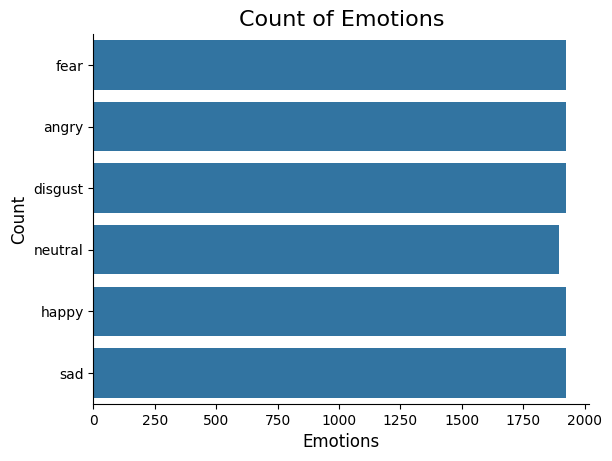

In [18]:
#Lets understand more about our data
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [19]:
#==>Almost a balanced datset

In [20]:
data,sr = librosa.load(file_path[0])
sr

22050

In [21]:
ipd.Audio(data,rate=sr)

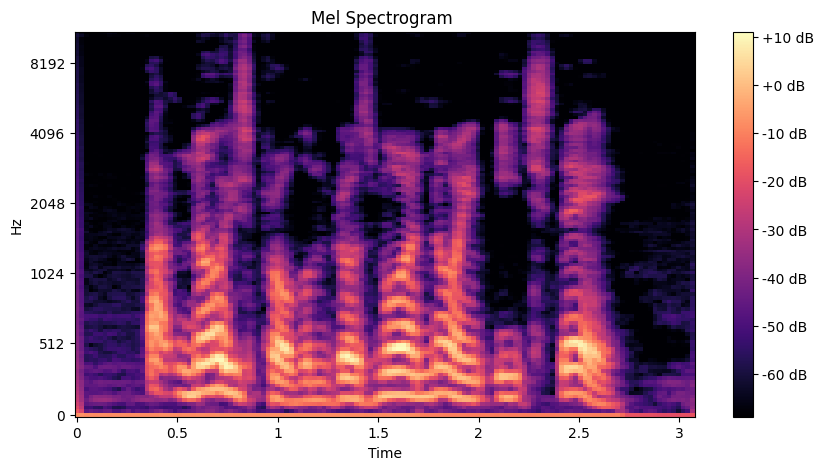

In [22]:
#lets create log mel spectrograms for more visualisation
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

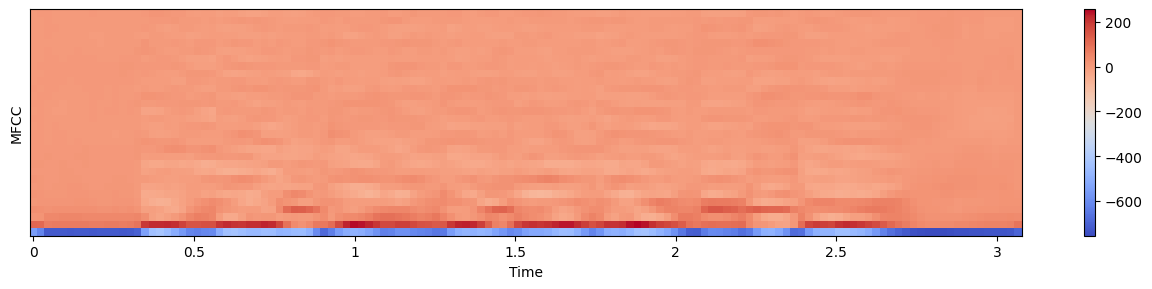

In [23]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)
#mfcc
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

In [24]:
#DATA AUGMENTATION!!
def noise(data):    #using noise
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch_manual(data, rate, sr):
    # Perform STFT
    D = librosa.stft(data)
    # Stretch the spectrogram using phase vocoding
    D_stretch = librosa.phase_vocoder(D, rate=rate)
    # Invert the STFT to get the time series
    y_stretch = librosa.istft(D_stretch)
    return y_stretch

def shift(data):                #using shift
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):      #using pitch
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

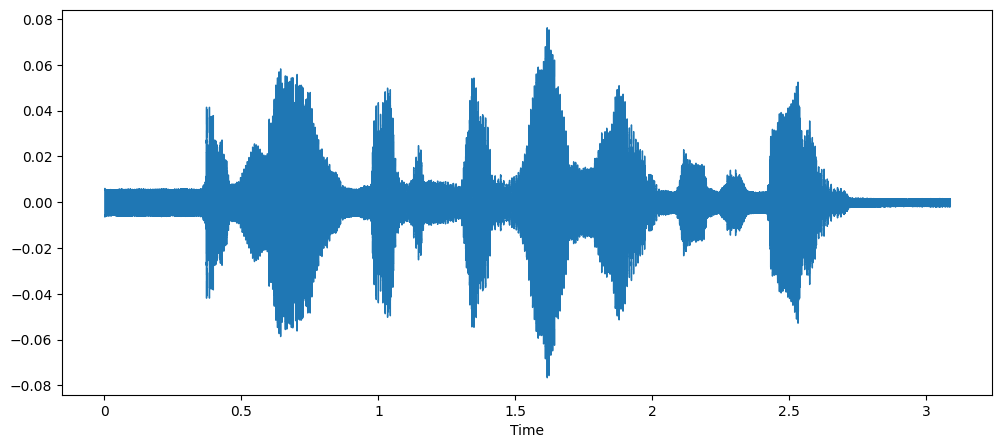

In [25]:
#Lets understand the changes

import librosa.display  #normal
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

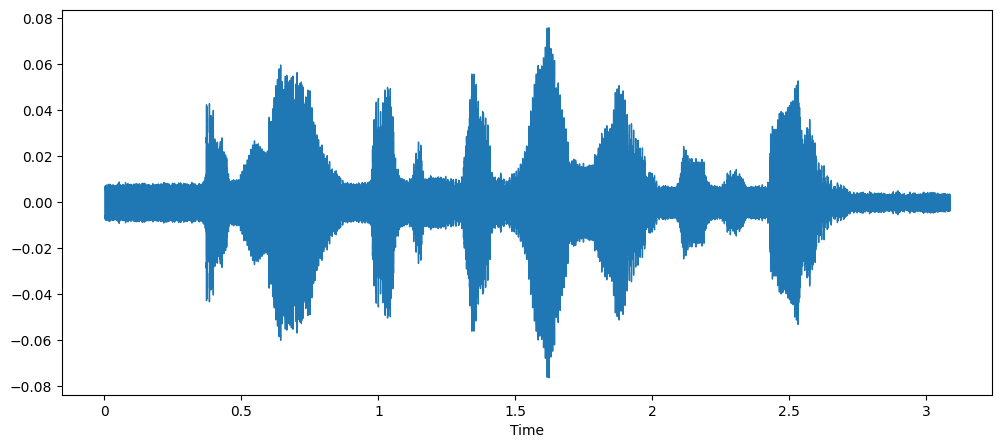

In [26]:
x = noise(data)   #with noise
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

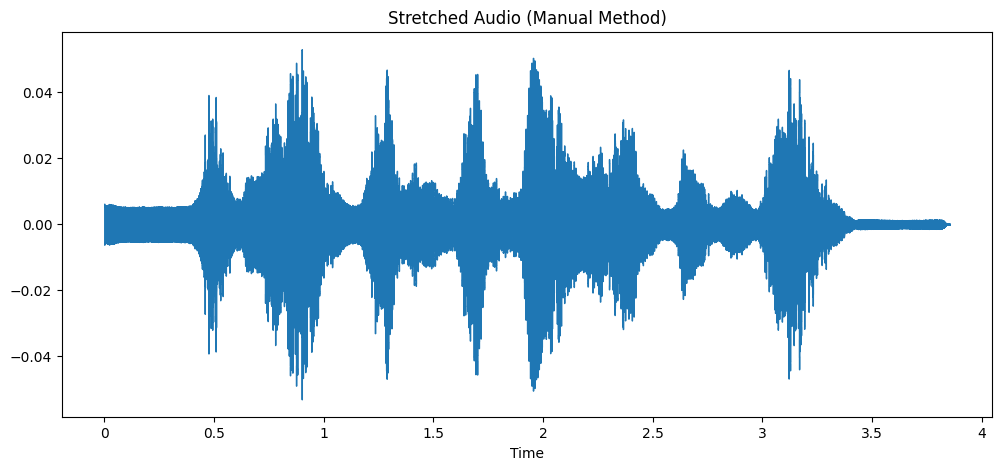

In [27]:
#Test the manual stretch function
x_stretched_manual = stretch_manual(data, rate=0.8, sr=sr)

plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x_stretched_manual, sr=sr)
plt.title('Stretched Audio (Manual Method)')
ipd.Audio(x_stretched_manual, rate=sr)

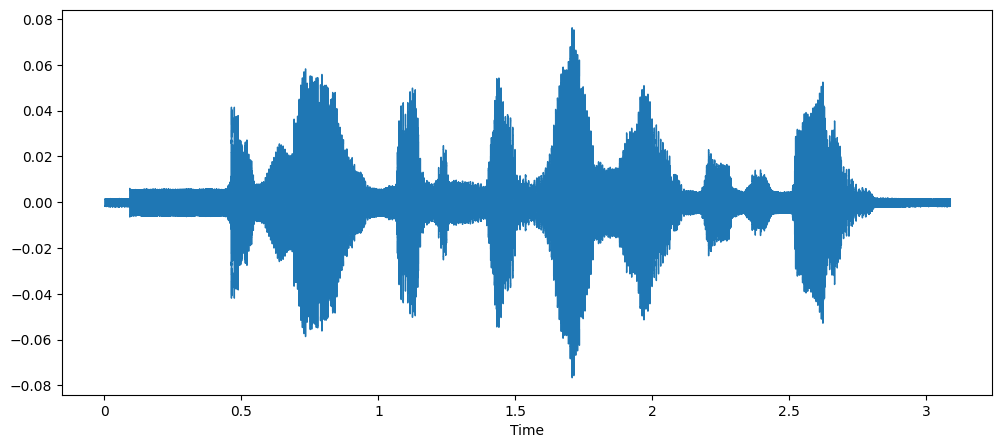

In [28]:
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

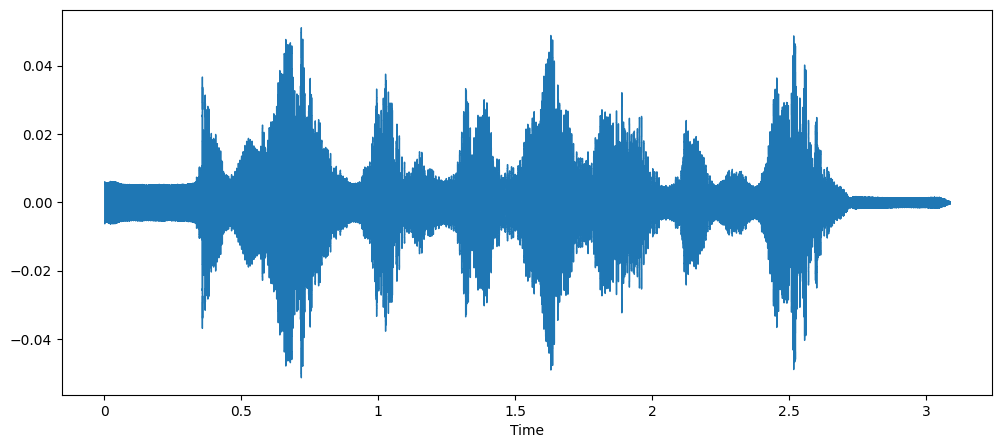

In [29]:
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)  #observe the reduced pitch

In [30]:
## feature extraction
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    # Pass the audio data to the 'y' keyword argument
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr) # Also pass data to 'y' for consistency and clarity
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

In [31]:
def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    # Renaming variables to avoid shadowing imported functions
    zcr_features = zcr(data,frame_length,hop_length)
    rmse_features = rmse(data,frame_length,hop_length)
    mfcc_features = mfcc(data,sr,frame_length,hop_length)

    result=np.hstack((result,
                      zcr_features,
                      rmse_features,
                      mfcc_features
                     ))
    return result

In [32]:
def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio

In [33]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:00,  1.87it/s]

0 audio has been processed


502it [00:54, 11.66it/s]

500 audio has been processed


1002it [01:49, 11.45it/s]

1000 audio has been processed


1501it [02:38,  5.22it/s]

1500 audio has been processed


2003it [03:24, 13.66it/s]

2000 audio has been processed


2504it [04:08, 14.95it/s]

2500 audio has been processed


3003it [04:52, 13.71it/s]

3000 audio has been processed


3502it [05:35, 13.37it/s]

3500 audio has been processed


4002it [06:19, 13.74it/s]

4000 audio has been processed


4502it [07:04, 14.37it/s]

4500 audio has been processed


5002it [07:47, 12.50it/s]

5000 audio has been processed


5502it [08:32, 11.58it/s]

5500 audio has been processed


6003it [09:19, 13.09it/s]

6000 audio has been processed


6502it [10:03, 13.59it/s]

6500 audio has been processed


7002it [10:48, 14.18it/s]

7000 audio has been processed


7502it [11:34, 13.78it/s]

7500 audio has been processed


8003it [12:19, 13.02it/s]

8000 audio has been processed


8502it [13:07,  6.72it/s]

8500 audio has been processed


9002it [13:53, 13.31it/s]

9000 audio has been processed


9502it [14:31,  5.92it/s]

9500 audio has been processed


10003it [15:05, 16.11it/s]

10000 audio has been processed


10503it [15:46, 12.79it/s]

10500 audio has been processed


11002it [16:25,  6.31it/s]

11000 audio has been processed


11503it [17:16, 11.28it/s]

11500 audio has been processed


11510it [17:17, 11.09it/s]

Done
Time:  1037.6080847990002


In [34]:
len(X), len(Y), data_path.Path.shape

(46040, 46040, (11510,))

In [35]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.062500,0.067383,0.080078,0.049805,0.084961,0.115234,0.138184,0.163574,0.157227,0.143555,...,5.801966,1.271988,6.636469,12.406131,9.032021,0.423571,-4.042969,-2.001393,1.681780,fear
1,0.258789,0.391602,0.519043,0.522461,0.517578,0.500000,0.496582,0.494629,0.486328,0.491211,...,-0.340013,0.218765,1.095609,1.171035,-4.524170,-6.463966,-4.312665,-0.100269,6.374051,fear
2,0.066406,0.073242,0.085449,0.054199,0.067871,0.078613,0.099121,0.105469,0.081055,0.073242,...,4.226560,5.615568,11.316467,11.948614,4.824253,-2.419646,-2.912810,0.670745,1.256788,fear
3,0.248535,0.375488,0.505859,0.497559,0.509766,0.508301,0.499023,0.500000,0.509277,0.516113,...,-3.242551,-0.892137,-0.448326,-1.879112,-3.171915,-4.692763,-7.225646,-2.609474,-3.360149,fear
4,0.079590,0.126465,0.151367,0.142578,0.133789,0.111816,0.123047,0.149414,0.183105,0.200195,...,-7.711326,-2.045660,-12.873043,-22.469097,-10.271768,-4.392125,-0.966868,1.431030,-10.825872,angry


In [36]:
#Now lets study emotions dataset

In [37]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [38]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(46040, 2377)

In [39]:
np.sum(Emotions.isna())

,0
0,0
1,0
2,0
3,0
4,0
...,...
2372,0
2373,0
2374,0
2375,0


In [40]:
#Data prep
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [41]:
#OHE on y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [42]:
print(Y.shape)
X.shape

(46040, 6)


(46040, 2376)

In [43]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((36832, 2376), (36832, 6), (9208, 2376), (9208, 6))

In [44]:
#Just using CNN as it gave better results compared to other architectures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

In [45]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),

     L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
     L.BatchNormalization(),
     L.MaxPool1D(pool_size=5,strides=2,padding='same'),

     L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
     L.BatchNormalization(),
     L.MaxPool1D(pool_size=5,strides=2,padding='same'),
     Dropout(0.2),

     L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
     L.BatchNormalization(),
     L.MaxPool1D(pool_size=3,strides=2,padding='same'),
     Dropout(0.2),

     L.Flatten(),
     L.Dense(512,activation='relu'),
     L.BatchNormalization(),
     L.Dense(6,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2376, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2376, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1188, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1188, 512)      │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1188, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 594, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 594, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 297, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 297, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 297, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 149, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 149, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,915,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,07

 Total params: 7,192,710 (27.44 MB)

 Trainable params: 7,188,358 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define callbacks
early_stop = EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [47]:
x_traincnn = np.expand_dims(x_train, axis=2)
x_testcnn = np.expand_dims(x_test, axis=2)

history = model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64, callbacks=[early_stop, lr_reduction, model_checkpoint])

Epoch 1/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.4347 - loss: 1.5414

576/576 ━━━━━━━━━━━━━━━━━━━━ 173s 268ms/step - accuracy: 0.4348 - loss: 1.5410 - val_accuracy: 0.5161 - val_loss: 1.2367 - learning_rate: 0.0010
Epoch 2/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5691 - loss: 1.1019

576/576 ━━━━━━━━━━━━━━━━━━━━ 169s 234ms/step - accuracy: 0.5691 - loss: 1.1018 - val_accuracy: 0.5960 - val_loss: 1.0521 - learning_rate: 0.0010
Epoch 3/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6330 - loss: 0.9549

576/576 ━━━━━━━━━━━━━━━━━━━━ 142s 234ms/step - accuracy: 0.6330 - loss: 0.9549 - val_accuracy: 0.6020 - val_loss: 1.0439 - learning_rate: 0.0010
Epoch 4/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6695 - loss: 0.8566

576/576 ━━━━━━━━━━━━━━━━━━━━ 135s 234ms/step - accuracy: 0.6695 - loss: 0.8566 - val_accuracy: 0.6144 - val_loss: 1.0207 - learning_rate: 0.0010
Epoch 5/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7274 - loss: 0.7235

576/576 ━━━━━━━━━━━━━━━━━━━━ 145s 240ms/step - accuracy: 0.7274 - loss: 0.7235 - val_accuracy: 0.7180 - val_loss: 0.7430 - learning_rate: 0.0010
Epoch 6/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 138s 234ms/step - accuracy: 0.7935 - loss: 0.5591 - val_accuracy: 0.6826 - val_loss: 0.8933 - learning_rate: 0.0010
Epoch 7/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8490 - loss: 0.4132

576/576 ━━━━━━━━━━━━━━━━━━━━ 142s 234ms/step - accuracy: 0.8490 - loss: 0.4132 - val_accuracy: 0.8166 - val_loss: 0.5023 - learning_rate: 0.0010
Epoch 8/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8944 - loss: 0.3014

576/576 ━━━━━━━━━━━━━━━━━━━━ 142s 234ms/step - accuracy: 0.8944 - loss: 0.3014 - val_accuracy: 0.8664 - val_loss: 0.3595 - learning_rate: 0.0010
Epoch 9/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9338 - loss: 0.2011

576/576 ━━━━━━━━━━━━━━━━━━━━ 135s 235ms/step - accuracy: 0.9338 - loss: 0.2011 - val_accuracy: 0.9152 - val_loss: 0.2438 - learning_rate: 0.0010
Epoch 10/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9492 - loss: 0.1501

576/576 ━━━━━━━━━━━━━━━━━━━━ 135s 235ms/step - accuracy: 0.9492 - loss: 0.1501 - val_accuracy: 0.9410 - val_loss: 0.1821 - learning_rate: 0.0010
Epoch 11/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 138s 240ms/step - accuracy: 0.9574 - loss: 0.1281 - val_accuracy: 0.9363 - val_loss: 0.1841 - learning_rate: 0.0010
Epoch 12/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9723 - loss: 0.0869

576/576 ━━━━━━━━━━━━━━━━━━━━ 139s 234ms/step - accuracy: 0.9723 - loss: 0.0869 - val_accuracy: 0.9524 - val_loss: 0.1386 - learning_rate: 0.0010
Epoch 13/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 138s 240ms/step - accuracy: 0.9760 - loss: 0.0762 - val_accuracy: 0.9481 - val_loss: 0.1569 - learning_rate: 0.0010
Epoch 14/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 142s 240ms/step - accuracy: 0.9658 - loss: 0.0977 - val_accuracy: 0.9441 - val_loss: 0.1607 - learning_rate: 0.0010
Epoch 15/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 142s 240ms/step - accuracy: 0.9798 - loss: 0.0639 - val_accuracy: 0.8828 - val_loss: 0.3549 - learning_rate: 0.0010
Epoch 16/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9816 - loss: 0.0564

576/576 ━━━━━━━━━━━━━━━━━━━━ 142s 240ms/step - accuracy: 0.9816 - loss: 0.0564 - val_accuracy: 0.9592 - val_loss: 0.1190 - learning_rate: 0.0010
Epoch 17/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 138s 240ms/step - accuracy: 0.9819 - loss: 0.0565 - val_accuracy: 0.9313 - val_loss: 0.2115 - learning_rate: 0.0010
Epoch 18/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 138s 240ms/step - accuracy: 0.9841 - loss: 0.0492 - val_accuracy: 0.9474 - val_loss: 0.1734 - learning_rate: 0.0010
Epoch 19/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9818 - loss: 0.0557

576/576 ━━━━━━━━━━━━━━━━━━━━ 139s 235ms/step - accuracy: 0.9818 - loss: 0.0557 - val_accuracy: 0.9759 - val_loss: 0.0852 - learning_rate: 0.0010
Epoch 20/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 145s 240ms/step - accuracy: 0.9867 - loss: 0.0437 - val_accuracy: 0.9571 - val_loss: 0.1406 - learning_rate: 0.0010
Epoch 21/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 139s 234ms/step - accuracy: 0.9844 - loss: 0.0469 - val_accuracy: 0.9662 - val_loss: 0.1027 - learning_rate: 0.0010
Epoch 22/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 142s 234ms/step - accuracy: 0.9848 - loss: 0.0445 - val_accuracy: 0.9695 - val_loss: 0.0968 - learning_rate: 0.0010
Epoch 23/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 141s 233ms/step - accuracy: 0.9884 - loss: 0.0336 - val_accuracy: 0.9712 - val_loss: 0.1006 - learning_rate: 0.0010
Epoch 24/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9896 - loss: 0.0312
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
576/576 ━━━━━━━━━━━━━━━━━━━━ 145s 240ms/step - accuracy: 0.98

576/576 ━━━━━━━━━━━━━━━━━━━━ 142s 240ms/step - accuracy: 0.9917 - loss: 0.0262 - val_accuracy: 0.9854 - val_loss: 0.0488 - learning_rate: 5.0000e-04
Epoch 26/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9972 - loss: 0.0107

576/576 ━━━━━━━━━━━━━━━━━━━━ 139s 240ms/step - accuracy: 0.9972 - loss: 0.0107 - val_accuracy: 0.9895 - val_loss: 0.0380 - learning_rate: 5.0000e-04
Epoch 27/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 138s 234ms/step - accuracy: 0.9970 - loss: 0.0101 - val_accuracy: 0.9885 - val_loss: 0.0426 - learning_rate: 5.0000e-04
Epoch 28/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9970 - loss: 0.0098

576/576 ━━━━━━━━━━━━━━━━━━━━ 145s 240ms/step - accuracy: 0.9970 - loss: 0.0098 - val_accuracy: 0.9907 - val_loss: 0.0352 - learning_rate: 5.0000e-04
Epoch 29/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 135s 234ms/step - accuracy: 0.9975 - loss: 0.0097 - val_accuracy: 0.9901 - val_loss: 0.0377 - learning_rate: 5.0000e-04
Epoch 30/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 138s 240ms/step - accuracy: 0.9962 - loss: 0.0119 - val_accuracy: 0.9873 - val_loss: 0.0493 - learning_rate: 5.0000e-04
Epoch 31/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9974 - loss: 0.0095

576/576 ━━━━━━━━━━━━━━━━━━━━ 139s 234ms/step - accuracy: 0.9974 - loss: 0.0095 - val_accuracy: 0.9917 - val_loss: 0.0324 - learning_rate: 5.0000e-04
Epoch 32/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 138s 240ms/step - accuracy: 0.9974 - loss: 0.0082 - val_accuracy: 0.9903 - val_loss: 0.0392 - learning_rate: 5.0000e-04
Epoch 33/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 142s 240ms/step - accuracy: 0.9971 - loss: 0.0097 - val_accuracy: 0.9864 - val_loss: 0.0573 - learning_rate: 5.0000e-04
Epoch 34/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 142s 240ms/step - accuracy: 0.9972 - loss: 0.0093 - val_accuracy: 0.9884 - val_loss: 0.0502 - learning_rate: 5.0000e-04
Epoch 35/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 139s 234ms/step - accuracy: 0.9964 - loss: 0.0114 - val_accuracy: 0.9872 - val_loss: 0.0494 - learning_rate: 5.0000e-04
Epoch 36/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9976 - loss: 0.0079
Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
576/576 ━━━━━━━━━━━━━━━━━━━━ 145s 239ms/s

576/576 ━━━━━━━━━━━━━━━━━━━━ 142s 240ms/step - accuracy: 0.9986 - loss: 0.0054 - val_accuracy: 0.9924 - val_loss: 0.0314 - learning_rate: 2.5000e-04
Epoch 38/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9990 - loss: 0.0040

576/576 ━━━━━━━━━━━━━━━━━━━━ 139s 234ms/step - accuracy: 0.9990 - loss: 0.0040 - val_accuracy: 0.9934 - val_loss: 0.0303 - learning_rate: 2.5000e-04
Epoch 39/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9991 - loss: 0.0036

576/576 ━━━━━━━━━━━━━━━━━━━━ 145s 240ms/step - accuracy: 0.9991 - loss: 0.0036 - val_accuracy: 0.9940 - val_loss: 0.0279 - learning_rate: 2.5000e-04
Epoch 40/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 138s 240ms/step - accuracy: 0.9987 - loss: 0.0039 - val_accuracy: 0.9929 - val_loss: 0.0298 - learning_rate: 2.5000e-04
Epoch 41/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 139s 234ms/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9903 - val_loss: 0.0353 - learning_rate: 2.5000e-04
Epoch 42/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 135s 234ms/step - accuracy: 0.9993 - loss: 0.0028 - val_accuracy: 0.9936 - val_loss: 0.0278 - learning_rate: 2.5000e-04
Epoch 43/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 145s 240ms/step - accuracy: 0.9990 - loss: 0.0036 - val_accuracy: 0.9936 - val_loss: 0.0269 - learning_rate: 2.5000e-04
Epoch 44/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9997 - loss: 0.0019
Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
576/576 ━━━━━━━━━━━━━━━━━━━━ 142s 239ms/s

576/576 ━━━━━━━━━━━━━━━━━━━━ 142s 240ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.9948 - val_loss: 0.0244 - learning_rate: 1.2500e-04
Epoch 49/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9995 - loss: 0.0020

576/576 ━━━━━━━━━━━━━━━━━━━━ 139s 234ms/step - accuracy: 0.9995 - loss: 0.0020 - val_accuracy: 0.9949 - val_loss: 0.0258 - learning_rate: 1.2500e-04
Epoch 50/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 142s 234ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9949 - val_loss: 0.0263 - learning_rate: 1.2500e-04


288/288 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.9964 - loss: 0.0195
Accuracy of our model on test data :  99.48957562446594 %


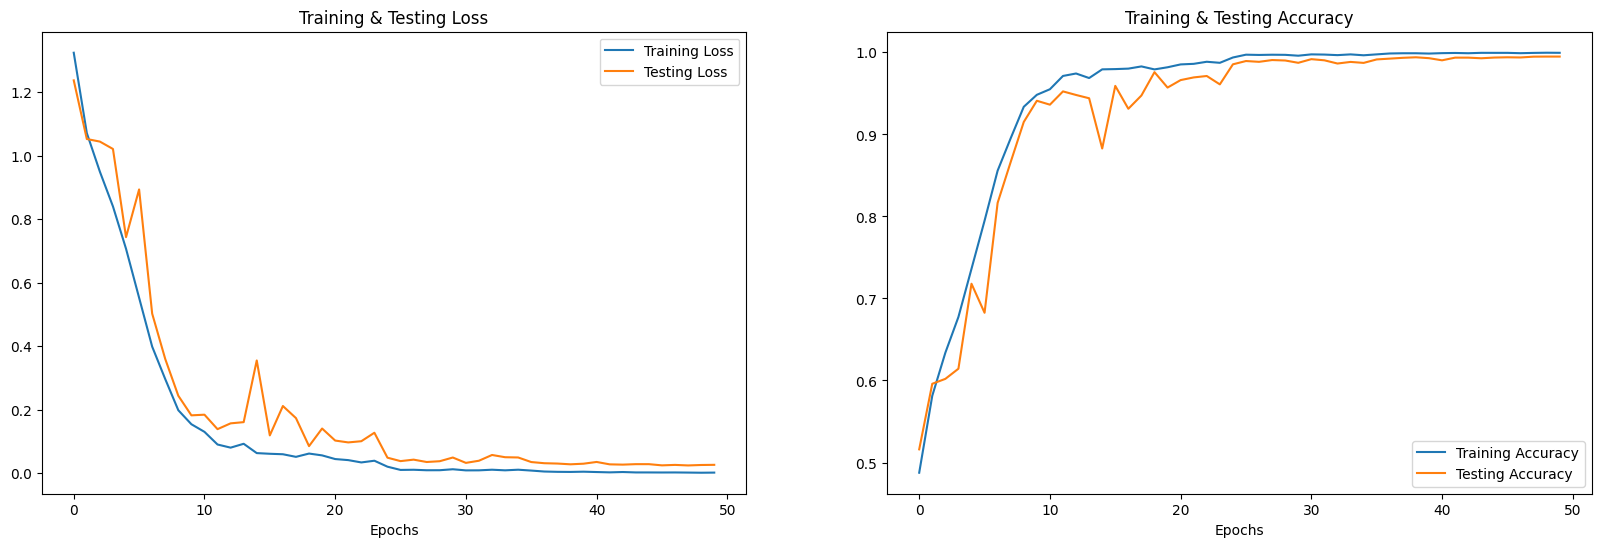

In [48]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [49]:
#predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

#check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step


,Predicted Labels,Actual Labels
0,angry,angry
1,disgust,disgust
2,neutral,neutral
3,fear,fear
4,fear,fear
5,angry,angry
6,happy,happy
7,neutral,neutral
8,fear,fear
9,angry,angry


In [50]:
df0

,Predicted Labels,Actual Labels
0,angry,angry
1,disgust,disgust
2,neutral,neutral
3,fear,fear
4,fear,fear
...,...,...
9203,angry,angry
9204,fear,fear
9205,sad,sad
9206,happy,happy


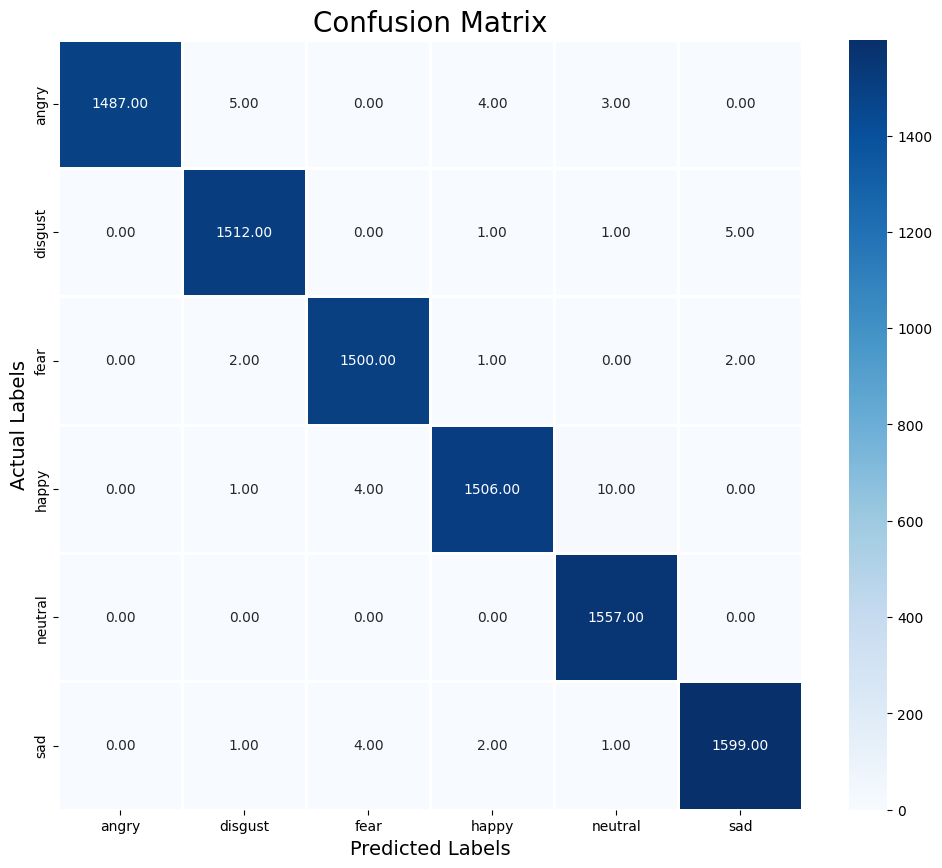

              precision    recall  f1-score   support

       angry       1.00      0.99      1.00      1499
     disgust       0.99      1.00      0.99      1519
        fear       0.99      1.00      1.00      1505
       happy       0.99      0.99      0.99      1521
     neutral       0.99      1.00      1.00      1557
         sad       1.00      1.00      1.00      1607

    accuracy                           0.99      9208
   macro avg       0.99      0.99      0.99      9208
weighted avg       0.99      0.99      0.99      9208



In [51]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))